Error loading /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/La-Liga/3825762_Sporting-Gijón_1_65.json: Invalid control character at: line 1 column 150 (char 149)
Error loading /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/La-Liga/3825808_Sporting-Gijón_0_65.json: Invalid control character at: line 1 column 168 (char 167)
Error loading /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/La-Liga/3825812_Sporting-Gijón_0_45.json: Invalid control character at: line 1 column 216 (char 215)
Error loading /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/La-Liga/3825705_Sporting-Gijón_0_62.json: Invalid control character at: line 1 column 306 (char 305)
Error loading /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/La-Liga/3825755_Sporting-Gijón_1_76.json: Invalid control character at: line 1 column 154 (char 153)
Error loading /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/La-Liga/3825741_Sporting-Gijón_4_

ValueError: 'c' argument has 3241 elements, which is inconsistent with 'x' and 'y' with size 3223.

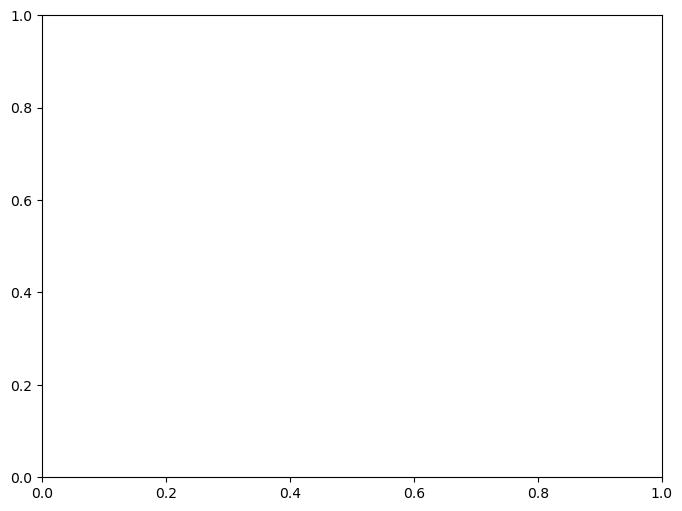

In [3]:
import os
import re
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ripser import ripser

# Function to construct adjacency matrix
def construct_adjacency_matrix(game_data):
    G = nx.Graph()
    max_count = max(pass_info["count"] for player in game_data for pass_info in player["passes"])

    for player in game_data:
        G.add_node(player['name'], pos=(player['x'], player['y']))

    for player in game_data:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            edge_weight = count / max_count
            G.add_edge(player1, player2, weight=edge_weight)

    return G

# Function to extract persistence diagram features
def extract_features(persistence_diagrams):
    features = []
    max_len = 0

    for diagram in persistence_diagrams:
        if diagram and len(diagram) > 0:
            diagram = np.array(diagram[0])
            lifespan = diagram[:, 1] - diagram[:, 0]
            features.append(lifespan)
            max_len = max(max_len, len(lifespan))
        else:
            features.append(np.zeros(1))

    padded_features = []
    for feature in features:
        if len(feature) < max_len:
            padded_features.append(np.pad(feature, (0, max_len - len(feature)), mode='constant'))
        else:
            padded_features.append(feature)

    return np.array(padded_features)

# Function to extract goals and time from file names
def extract_goals_and_time(file_name):
    match = re.search(r"_(\d+)_(\d+)\.json", file_name)
    if match:
        goals = int(match.group(1))
        time = int(match.group(2))
        return goals / time * 90  # Normalize to 90 minutes
    return 0

# Function to clean and parse JSON files
def clean_json(file_path):
    with open(file_path, 'r') as f:
        data = f.read()
    try:
        return json.loads(data)
    except json.JSONDecodeError:
        # Attempt to clean common problematic characters
        clean_data = data.replace('\r', '').replace('\n', '').replace('\t', '').replace('\\', '')
        try:
            return json.loads(clean_data)
        except json.JSONDecodeError as e:
            print(f"Failed to clean {file_path}: {e}")
            return None

# Define folder paths
folder_paths = [
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga',
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/La-Liga',
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Ligue-1',
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Premier-League',
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Serie-A'
]

# Collect all file paths
file_paths = []
for folder in folder_paths:
    if os.path.exists(folder):
        file_paths.extend([os.path.join(folder, filename) for filename in os.listdir(folder) if filename.endswith('.json')])

# Load and clean JSON files
data = []
invalid_files = []

for file_path in file_paths:
    cleaned_data = clean_json(file_path)
    if cleaned_data:
        data.append(cleaned_data)
    else:
        invalid_files.append(file_path)

# Log invalid files
if invalid_files:
    print(f"Skipped {len(invalid_files)} invalid files.")
    print("List of invalid files:")
    for invalid_file in invalid_files:
        print(invalid_file)

# Construct passing networks and compute persistence diagrams
persistence_diagrams = []
for match_data in data:
    try:
        G = construct_adjacency_matrix(match_data)
        adj_matrix = nx.to_numpy_array(G)
        persistence_diagrams.append(ripser(adj_matrix, distance_matrix=True)['dgms'])
    except Exception as e:
        print(f"Error processing match data: {e}")

# Extract features from persistence diagrams
if persistence_diagrams:
    features = extract_features(persistence_diagrams)

    # Handle NaN or infinity values
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)

    # Extract goals per 90 minutes
    goals_per_90 = [extract_goals_and_time(os.path.basename(file_path)) for file_path in file_paths]

    # Visualize PCA features with a heatmap
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=goals_per_90, cmap='coolwarm', edgecolor='k', alpha=0.7)
    cb = plt.colorbar(label='Goals per 90 Minutes')
    plt.title("Heatmap of PCA Features with Goals per 90 Minutes", fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)
    plt.grid(False)
    plt.show()
else:
    print("No valid persistence diagrams were computed.")